In [ ]:
!pip install bayesian-optimization
!pip install GPyOpt

In [2]:
#import packages
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn import ensemble
from sklearn.metrics import mean_squared_error,accuracy_score
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
import seaborn as sns

In [3]:
#reading csv file for Boston Housing Dataset
from google.colab import files
uploaded = files.upload()
import io
df = pd.read_csv(io.BytesIO(uploaded['hou_all.csv']),\
                 names = ['CRIM','ZN','INDUS','CHAS','NOS','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])
df.head()

Saving hou_all.csv to hou_all.csv


,CRIM,ZN,INDUS,CHAS,NOS,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
#parameters = CRIM , ZN, INDUS
X = df.iloc[:,0:3].to_numpy()

#target = MEDV
Y = df.iloc[:,-1].to_numpy()

#train test split
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size = 0.3, random_state = 10)

#building rf regression model
rf = RandomForestRegressor()
rf.fit(xTrain,yTrain)
yPred = rf.predict(xTest)

#calculating loss - MSE
MSE = mean_squared_error(yPred,yTest)

In [ ]:
def bo_params_rf(max_samples,n_estimators,max_features):
    
    params = {
        'max_samples': max_samples,
        'max_features':max_features,
        'n_estimators':int(n_estimators)
    }
    clf = RandomForestRegressor(max_samples=params['max_samples'],max_features=params['max_features'],n_estimators=params['n_estimators'])
    clf.fit(xTrain,yTrain)
    yPred = clf.predict(xTest)
    
    #using negative MSE as score (loss function)
    score = -mean_squared_error(yPred,yTest)
    return score

In [ ]:
#boundary for Bayesian optimization
bounds = {'max_samples':(0.5,1),
          'max_features':(0.5,1),
          'n_estimators':(100,200)}

rf_bo = BayesianOptimization(bo_params_rf, bounds)

results = rf_bo.maximize(n_iter=20, init_points=5)

|   iter    |  target   | max_fe... | max_sa... | n_esti... |
-------------------------------------------------------------
| 1         | -61.52    | 0.6343    | 0.6539    | 105.6     |
| 2         | -62.95    | 0.5864    | 0.832     | 148.4     |
| 3         | -61.7     | 0.863     | 0.7026    | 165.4     |
| 4         | -64.5     | 0.6882    | 0.9884    | 178.5     |
| 5         | -64.58    | 0.6269    | 0.8708    | 191.8     |
| 6         | -63.27    | 0.5305    | 0.8192    | 113.4     |
| 7         | -61.67    | 0.8827    | 0.6777    | 191.3     |
| 8         | -62.49    | 0.7959    | 0.6257    | 172.6     |
| 9         | -63.18    | 0.7019    | 0.6133    | 160.6     |
| 10        | -61.09    | 0.9562    | 0.6174    | 169.1     |
| 11        | -60.29    | 0.582     | 0.6215    | 105.9     |
| 12        | -62.31    | 0.5694    | 0.7176    | 168.1     |
| 13        | -63.63    | 0.6954    | 0.8278    | 106.0     |
| 14        | -64.69    | 0.7475    | 0.8978    | 129.1     |
| 15    

In [ ]:
params = rf_bo.max['params']
params['n_estimators']= int(params['n_estimators'])
print(params)

{'max_features': 0.5820176314426827, 'max_samples': 0.6215203264475643, 'n_estimators': 105}


In [5]:
#using GPyOpt
import GPyOpt

list_max_samples=[]
list_max_features=[]
list_n_estimators=[]
list_score=[]

bounds = [ {'name': 'max_samples', 'type': 'continuous', 'domain': (0.5, 1)},
        {'name': 'max_features', 'type': 'continuous', 'domain': (0.5, 1)},
        {'name': 'n_estimators', 'type': 'discrete', 'domain': (100,120,140,160,180,200)}
      ]

def rf_score(parameters):
  parameters = parameters[0]
  params = {
        'max_samples': parameters[0],
        'max_features':parameters[1],
        'n_estimators':int(parameters[2])
    }
  
  reg = RandomForestRegressor(max_samples=params['max_samples'],max_features=params['max_features'],n_estimators=params['n_estimators'])
  reg.fit(xTrain,yTrain)
  yPred = reg.predict(xTest)
    
  #using negative MSE as score (loss function)
  score = -mean_squared_error(yPred,yTest)

  list_max_samples.append(params['max_samples'])
  list_max_features.append(params['max_features'])
  list_n_estimators.append(params['n_estimators'])
  list_score.append(-score)

  return score

In [6]:
optimizer = GPyOpt.methods.BayesianOptimization(f=rf_score, 
                                                   domain=bounds,
                                                   acquisition_type ='EI',
                                                   initial_design_numdata = 5,
                                                   model_type='GP',
                                                   acquisition_jitter = 0.05,
                                                   maximize=True
                                                   )

optimizer.run_optimization(max_iter=20)

#minimum MSE
MSE_min=-optimizer.fx_opt
#best parameters
params_min=optimizer.x_opt
print(MSE_min)
print(params_min)

-58.87445574687744
[  0.52611945   0.51353159 180.        ]


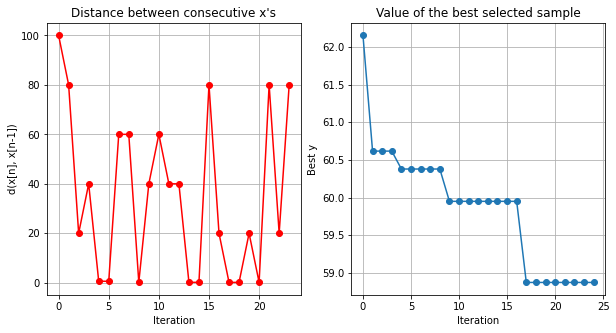

In [7]:
optimizer.plot_convergence()

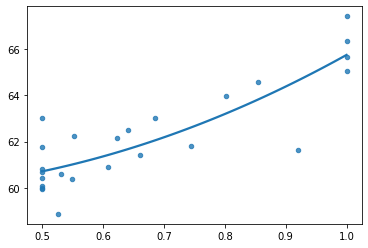

In [8]:
sns.regplot(x=list_max_samples, y=list_score, order=2, ci=None, scatter_kws={"s": 20});

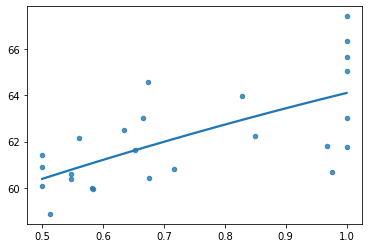

In [9]:
sns.regplot(x=list_max_features, y=list_score, order=2, ci=None, scatter_kws={"s": 20});

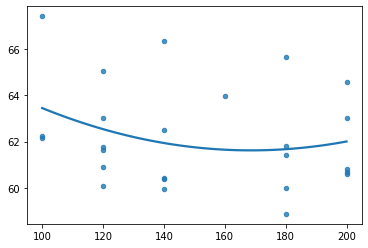

In [10]:
sns.regplot(x=list_n_estimators, y=list_score, order=2, ci=None, scatter_kws={"s": 20});